# Collaboration and Competition

---

In this notebook, we will make use of the Unity ML-Agents environment.

### 1. Start the Environment

We begin by importing the necessary packages. Please make sure to install [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).  

In [1]:
#Don't need to run this cell. Check out the dependencies in README file
#!pip -q install ./python

In [2]:
#Don't need to run this cell. This is only required during the training in Udacity workspaces
#from workspace_utils import active_session

In [3]:
from unityagents import UnityEnvironment
import numpy as np

In [4]:
import random
import copy
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [5]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils as U

In [6]:
from collections import namedtuple, deque

In [7]:
from model import Actor, Critic
from utils import sample, update_targets, OUNoise

In [8]:
## Hyperparameters

## For Experience Replay
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128         # minibatch size

## For Fixed-Q Target
TAU = 1e-3              # for soft update of target parameters
UPDATE_EVERY = 1       # how often to update the network. 
UPDATE_TIMES = 1       # and how many times to update

# For Cumulative Reward
GAMMA = 0.99            # discount factor

## For Q Network
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic

WEIGHT_DECAY = 0        # L2 weight decay

OU_SIGMA = 0.2          # Ornstein-Uhlenbeck noise parameter
OU_THETA = 0.15         # Ornstein-Uhlenbeck noise parameter

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
state_size = 24
action_size = 2
random_seed = 1
random.seed(random_seed)

In [11]:
## AGENT No. 1 

# Actor Network (w/ Target Network)
actor_local1 = Actor(state_size+1, action_size, random_seed).to(device)
actor_target1 = Actor(state_size+1, action_size, random_seed).to(device)
actor_optimizer1 = optim.Adam(actor_local1.parameters(), lr=LR_ACTOR)

# Critic Network (w/ Target Network)
critic_local1 = Critic(state_size+1, action_size, random_seed).to(device)
critic_target1 = Critic(state_size+1, action_size, random_seed).to(device)
critic_optimizer1 = optim.Adam(critic_local1.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

In [12]:
## AGENT No. 2 

# Actor Network (w/ Target Network)
actor_local2 = Actor(state_size+1, action_size, random_seed).to(device)
actor_target2 = Actor(state_size+1, action_size, random_seed).to(device)
actor_optimizer2 = optim.Adam(actor_local2.parameters(), lr=LR_ACTOR)


# Critic Network (w/ Target Network)
critic_local2 = Critic(state_size+1, action_size, random_seed).to(device)
critic_target2 = Critic(state_size+1, action_size, random_seed).to(device)
critic_optimizer2 = optim.Adam(critic_local2.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

In [13]:
update_targets(critic_local1, critic_target1)
update_targets(actor_local1, actor_target1)        
update_targets(critic_local2, critic_target2)
update_targets(actor_local2, actor_target2)   

In [14]:
# some util and data variables
mu = 0.
replay_memory = deque(maxlen=BUFFER_SIZE) # same memory will be used for both the agents to implement MADDPG
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
# Noise process
noise = OUNoise(action_size, random_seed, mu, OU_SIGMA, OU_THETA)

Next, we will start the environment!

In [15]:
#Run this cell in Udacity workspace. Otherwise run the cell below

#env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

In [16]:
#Run this cell locally on mac only. Otherwise run the above cell.

env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [17]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [18]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment (Optional Step)

In the next code cell, we will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, we will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows us to observe the agent, as it moves through the environment.  

In [19]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    steps = 0
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        steps += 1
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
    print('Total steps in this episode: {}'.format(steps))

Total score (averaged over agents) this episode: -0.004999999888241291
Total steps in this episode: 14
Total score (averaged over agents) this episode: -0.004999999888241291
Total steps in this episode: 17
Total score (averaged over agents) this episode: -0.004999999888241291
Total steps in this episode: 15
Total score (averaged over agents) this episode: -0.004999999888241291
Total steps in this episode: 15
Total score (averaged over agents) this episode: -0.004999999888241291
Total steps in this episode: 14


### 4. Define Agent

In [20]:
## Agent - one of the core logic of DDPG - To run INFERENCE on Actor Neural Network
def agent(actor_local, state, add_noise=True):
    """Returns actions for given state as per current policy."""
    state = torch.from_numpy(state).float().to(device)
    actor_local.eval()
    with torch.no_grad():
        action = actor_local(state).cpu().data.numpy()
    actor_local.train()
    if add_noise:
        action +=noise.sample()
    return np.clip(action, -1, 1)

### 5. Define Training of the Agent

Or go straight to step 8 to test agent loaded with previuous trained weights (in its Neural Network)

In [21]:
## Train Agent - One of the core logic of DDPG - To TRAIN Actor and Critic Neural NETWORK
def train_agent(state, action, reward, next_state, done, timestep, 
                actor_local, actor_target, actor_optimizer, critic_local, critic_target, critic_optimizer):
    """Update policy and value parameters using given batch of experience tuples.
    Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
    where:
        actor_target(state) -> action
        critic_target(state, action) -> Q-value

    Params
    ======
        experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
        gamma (float): discount factor
    """
    """Save experience in replay memory, and use random sample from buffer to learn."""
       
    e = experience(state, action, reward, next_state, done)
    # Save experience / reward
    replay_memory.append(e)
        
    # Learn, if enough samples are available in memory
    if len(replay_memory) > BATCH_SIZE and timestep % UPDATE_EVERY == 0:
        for _ in range(UPDATE_TIMES):
            
            experiences = sample(replay_memory, BATCH_SIZE)
            states, actions, rewards, next_states, dones = experiences

            # ---------------------------- update critic ---------------------------- #
            # Get predicted next-state actions and Q values from target models
            actions_next = actor_target(next_states)
            Q_targets_next = critic_target(next_states, actions_next)
            # Compute Q targets for current states (y_i)
            Q_targets = rewards + (GAMMA * Q_targets_next * (1 - dones))
            # Compute critic loss
            Q_expected = critic_local(states, actions)
            critic_loss = F.mse_loss(Q_expected, Q_targets)
            # Minimize the loss
            critic_optimizer.zero_grad()
            critic_loss.backward()
            U.clip_grad_norm_(critic_local.parameters(), 1)
            critic_optimizer.step()


            # ---------------------------- update actor ---------------------------- #
            # Compute actor loss
            actions_pred = actor_local(states)
            actor_loss = -critic_local(states, actions_pred).mean()
            # Minimize the loss
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            # ----------------------- update target networks ----------------------- #
            update_targets(critic_local, critic_target, TAU)
            update_targets(actor_local, actor_target, TAU) 

### 6. Main Function - Define and Run Training

Or go straight to step 8 to test agent loaded with previous trained weights (in its Neural Network)

Episode 100	 Mean Score for Agent 1: -0.000, Mean Score for Agent 2: -0.001, Mean Score of both Agents: -0.001
Episode 200	 Mean Score for Agent 1: -0.005, Mean Score for Agent 2: -0.005, Mean Score of both Agents: -0.005
Episode 300	 Mean Score for Agent 1: -0.004, Mean Score for Agent 2: -0.006, Mean Score of both Agents: -0.005
Episode 400	 Mean Score for Agent 1: -0.006, Mean Score for Agent 2: -0.004, Mean Score of both Agents: -0.005
Episode 500	 Mean Score for Agent 1: 0.001, Mean Score for Agent 2: 0.000, Mean Score of both Agents: 0.001
Episode 600	 Mean Score for Agent 1: 0.005, Mean Score for Agent 2: 0.007, Mean Score of both Agents: 0.006
Episode 700	 Mean Score for Agent 1: 0.004, Mean Score for Agent 2: -0.003, Mean Score of both Agents: 0.001
Episode 800	 Mean Score for Agent 1: 0.004, Mean Score for Agent 2: -0.003, Mean Score of both Agents: 0.001
Episode 900	 Mean Score for Agent 1: 0.009, Mean Score for Agent 2: -0.005, Mean Score of both Agents: 0.002
Episode 1000	

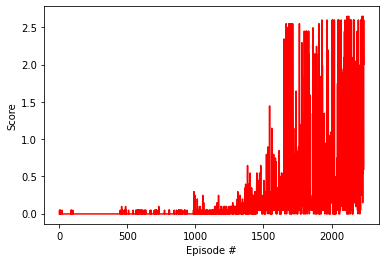

In [22]:
def ddpg(n_episodes=4000, target_score=0.5, print_every=100):
    #Some utility score variables
    scores1 = []
    scores2 = []
    mean_scores = []   
    for i_episode in range(1, n_episodes+1):
        #reset the environment, noise and score
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations              # get current state
        noise.reset()                                     # reset the noise        
        #reset the score for each agent
        score1 = 0
        score2 = 0
        #reset some utility counter
        t = 0
        while True: 
            t += 1
            state1 = np.concatenate([state[0], [1]]).reshape((1,state.shape[1]+1))
            state2 = np.concatenate([state[1], [-1]]).reshape((1,state.shape[1]+1))
            # select action with exploration 
            action1 = agent(actor_local1, state1, add_noise=True) 
            action2 = agent(actor_local2, state2, add_noise=True) 
            #Step the agents actions into the environment, and get reward, next state, etc
            env_info = env.step([action1, action2])[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            #Get the next_state for each agent from the main next_state variable
            next_state1 = np.concatenate([next_state[0], [1]])
            next_state2 = np.concatenate([next_state[1], [-1]])
            #Train both the agents now - Actor and Critic Neural Networks 
            train_agent(state1, action1, np.mean(reward), next_state1, done[0], t,
                        actor_local1, actor_target1, actor_optimizer1, critic_local1, critic_target1, critic_optimizer1)                   
            train_agent(state2, action2, np.mean(reward), next_state2, done[1], t,
                        actor_local2, actor_target2, actor_optimizer2, critic_local1, critic_target1, critic_optimizer2)                   
            #Make next_state as current state and continue
            state = next_state
            # add reward to current score of each agent
            score1 += reward[0]
            score2 += reward[1]                  
            # exit loop when episode ends
            if np.all(done):            
                break     
        
        scores1.append(score1)
        scores2.append(score2)
        mean_scores.append(np.mean([score1, score2]))
        mean1 = np.mean(scores1[-100:])
        mean2 = np.mean(scores2[-100:])
        mean_score = np.mean(mean_scores[-100:])
        if i_episode % print_every==0:
            print('Episode {}\t Mean Score for Agent 1: {:.3f}, Mean Score for Agent 2: {:.3f}, Mean Score of both Agents: {:.3f}'.format(
            i_episode, mean1, mean2, mean_score))
            
        if i_episode % 100 == 0:
            torch.save(actor_local1.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(critic_local1.state_dict(), 'checkpoint_critic_1.pth')
            torch.save(actor_local2.state_dict(), 'checkpoint_actor_2.pth')
            torch.save(critic_local2.state_dict(), 'checkpoint_critic_2.pth')
        if mean_score>1:
            break

    return mean_scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, 'r-')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 8. Test Trained Agent in the Environment

Once this cell is executed, we can watch the agent's performance.  A window should pop up that allows us to observe the agent, as it moves through the environment. 

In [26]:
#Load the previous trained weights
#Need to turn on the GPU to even test it. Otherwise torch load results in error. 
actor_local1.load_state_dict(torch.load('checkpoint_actor_1.pth'))
critic_local1.load_state_dict(torch.load('checkpoint_critic_1.pth'))
actor_local2.load_state_dict(torch.load('checkpoint_actor_2.pth'))
critic_local2.load_state_dict(torch.load('checkpoint_critic_2.pth'))

for i in range(5):  
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    steps = 0
    while True:
        state1 = np.concatenate([states[0], [1]]).reshape((1,states.shape[1]+1))
        state2 = np.concatenate([states[1], [-1]]).reshape((1,states.shape[1]+1))
        # select action with learned agent 
        action1 = agent(actor_local1, state1, add_noise=False) 
        action2 = agent(actor_local2, state2, add_noise=False) 
        #Step the agents actions into the environment, and get reward, next state, etc
        env_info = env.step([action1, action2])[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done 
        scores += env_info.rewards                         # update the score (for each agent)
        #Make next_state as current state and continue
        states = next_states 
        steps += 1
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
    print('Total steps in this episode: {}'.format(steps))           

Total score (averaged over agents) this episode: 2.5450000381097198
Total steps in this episode: 990
Total score (averaged over agents) this episode: 2.045000030659139
Total steps in this episode: 793
Total score (averaged over agents) this episode: 1.3950000209733844
Total steps in this episode: 548
Total score (averaged over agents) this episode: 0.1450000023469329
Total steps in this episode: 73
Total score (averaged over agents) this episode: 2.4950000373646617
Total steps in this episode: 966


When finished, you can close the environment.

In [22]:
env.close()